<a href="https://colab.research.google.com/github/LeDucDiLac/anti-spoofing-w-dinov2/blob/main/DINOv2_flash_Train_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from torch import nn, optim
from google.colab import drive
from tqdm import tqdm

drive.mount("/content/drive")

# Define datasets and models
class FeatureDataset(Dataset):
    def __init__(self, features, labels, paths):
        self.features = features
        self.labels = labels
        self.paths = paths

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.paths[idx]


# Load datasets
dev_features_path = "/content/drive/MyDrive/antispoofing/features-LCC_dev-dinov2_vitb14.npy"
dev_labels_path = "/content/drive/MyDrive/antispoofing/labels-LCC_dev-dinov2_vitb14.npy"
dev_paths_path = "/content/drive/MyDrive/antispoofing/paths-LCC_dev-dinov2_vitb14.npy"

features_5k_path = "/content/drive/MyDrive/antispoofing/features_b14.npy"
labels_5k_path = "/content/drive/MyDrive/antispoofing/labels_b14.npy"
paths_5k_path = "/content/drive/MyDrive/antispoofing/paths_b14.npy"

LCC_train_features_path = "/content/drive/MyDrive/antispoofing/features-LCC_train-dinov2_vitb14.npy"
LCC_train_labels_path = "/content/drive/MyDrive/antispoofing/labels-LCC_train-dinov2_vitb14.npy"
LCC_train_paths_path = "/content/drive/MyDrive/antispoofing/paths-LCC_train-dinov2_vitb14.npy"


_5k_features = np.load(features_5k_path)
_5k_labels = np.load(labels_5k_path)
_5k_paths = np.load(paths_5k_path, allow_pickle=True)

dev_features = np.load(dev_features_path)
dev_labels = np.load(dev_labels_path)
dev_paths = np.load(dev_paths_path, allow_pickle=True)

LCC_train_features = np.load(LCC_train_features_path)
LCC_train_labels = np.load(LCC_train_labels_path)
LCC_train_paths = np.load(LCC_train_paths_path, allow_pickle=True)

_5k_features = torch.tensor(_5k_features, dtype=torch.float32)
_5k_labels = torch.tensor(_5k_labels, dtype=torch.long)
dev_features = torch.tensor(dev_features, dtype=torch.float32)
dev_labels = torch.tensor(dev_labels, dtype=torch.long)
LCC_train_features = torch.tensor(LCC_train_features, dtype=torch.float32)
LCC_train_labels = torch.tensor(LCC_train_labels, dtype=torch.long)

_5k_dataset = FeatureDataset(_5k_features, _5k_labels, _5k_paths)
dev_dataset = FeatureDataset(dev_features, dev_labels, dev_paths)
LCC_train_dataset = FeatureDataset(LCC_train_features, LCC_train_labels, LCC_train_paths)

train_dataset = ConcatDataset([_5k_dataset, LCC_train_dataset])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

# Model configurations
input_dim = 768
output_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using ", device)
print("Training set size: ", len(train_dataset))
print("Development set size: ", len(dev_dataset))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using  cuda
Training set size:  13432
Development set size:  2948


# We define the multiple models training  function

In [ ]:
def trainMultipleModels(nn_configurations, nnClass, input_dim, output_dim, learning_rate=1e-3, epochs=300):
    results = {}
    models = {}
    for name, layers in nn_configurations.items():
        print(f"Training {name}...")
        model = nnClass(layers, input_dim, output_dim).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                        max_lr=0.01,
                                                        steps_per_epoch=len(train_loader),
                                                        epochs=epochs)

        # Training
        for epoch in tqdm(range(epochs)):
            model.train()
            for batch_features, batch_labels, _ in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

        models[name] = model.state_dict()

        # Evaluation
        model.eval()
        all_labels = []
        all_predictions = []
        misclassified_paths = []
        with torch.no_grad():
            for batch_features, batch_labels, batch_paths in dev_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                _, predictions = torch.max(outputs, 1)
                all_labels.extend(batch_labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                for i, (label, pred, path) in enumerate(zip(batch_labels.cpu().numpy(), predictions.cpu().numpy(), batch_paths)):
                    if label != pred:
                        misclassified_paths.append((path, label, pred))

        accuracy = accuracy_score(all_labels, all_predictions) * 100
        results[name] = {"accuracy": accuracy, "misclassified_paths": misclassified_paths,
                         "predictions": all_predictions, "labels": all_labels}
        print(f"{name} Accuracy: {accuracy:.2f}%")

    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), [result["accuracy"] for result in results.values()])
    plt.title("Accuracy Comparison Across Models")
    plt.xlabel("Model")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    # Display confusion matrices
    for name, result in results.items():
        print(f"Confusion Matrix for {name}")
        conf_matrix = confusion_matrix(result["labels"], result["predictions"])
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
        disp.plot(cmap="viridis", values_format="d")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

    return models


# First off, try simple model without batch norm

In [ ]:
input_dim = 768
output_dim = 2
class SimpleNN(nn.Module):
    def __init__(self, layers, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        for layer_dim in layers:
            self.layers.append(nn.Linear(prev_dim, layer_dim))
            self.layers.append(nn.ReLU())
            prev_dim = layer_dim
        self.layers.append(nn.Linear(prev_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



nn_configurations = {
    "Sigmoid": [],
    "2-layer NN": [128, 64],
    "3-layer NN": [256, 128, 64],
    "4-layer NN": [512, 256, 128, 64],
    "5-layer NN": [512, 256, 128, 64, 32],
}

# Training and evaluation


Training Sigmoid...


100%|██████████| 300/300 [03:04<00:00,  1.62it/s]


Sigmoid Accuracy: 95.01%
Training 2-layer NN...


100%|██████████| 300/300 [03:47<00:00,  1.32it/s]


2-layer NN Accuracy: 97.18%
Training 3-layer NN...


100%|██████████| 300/300 [04:27<00:00,  1.12it/s]


3-layer NN Accuracy: 86.26%
Training 4-layer NN...


100%|██████████| 300/300 [05:10<00:00,  1.04s/it]


4-layer NN Accuracy: 86.26%
Training 5-layer NN...


100%|██████████| 300/300 [05:29<00:00,  1.10s/it]


5-layer NN Accuracy: 86.26%


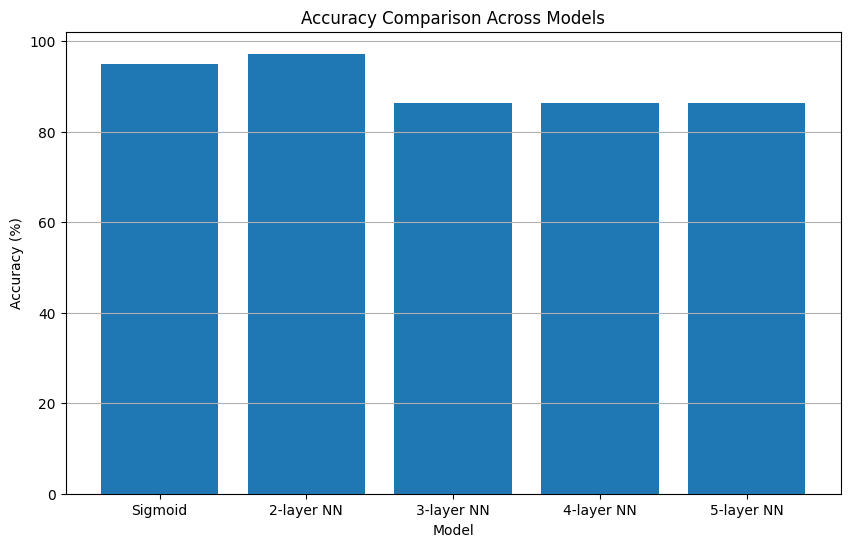

Confusion Matrix for Sigmoid


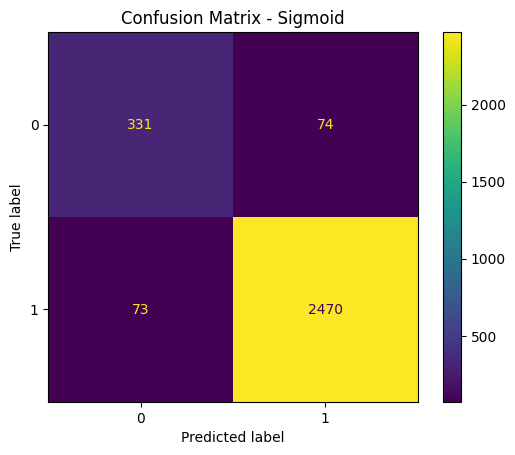

Confusion Matrix for 2-layer NN


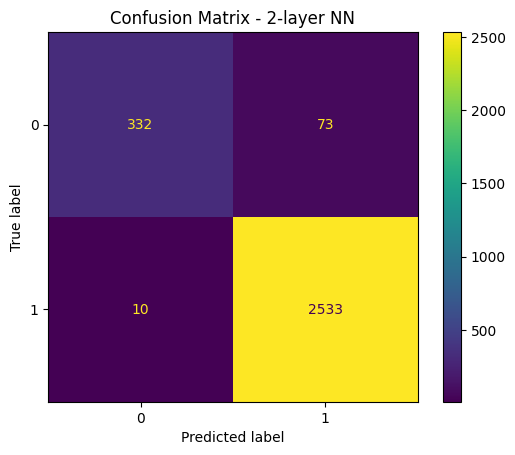

Confusion Matrix for 3-layer NN


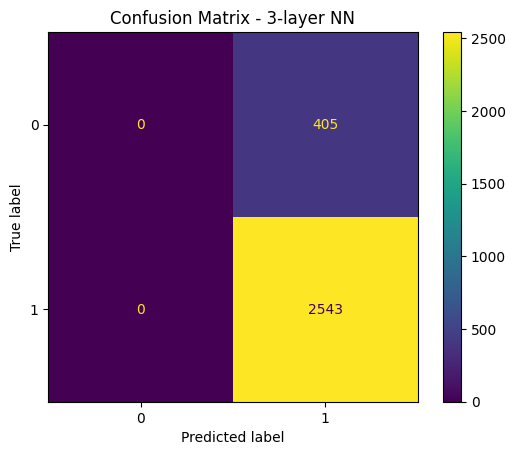

Confusion Matrix for 4-layer NN


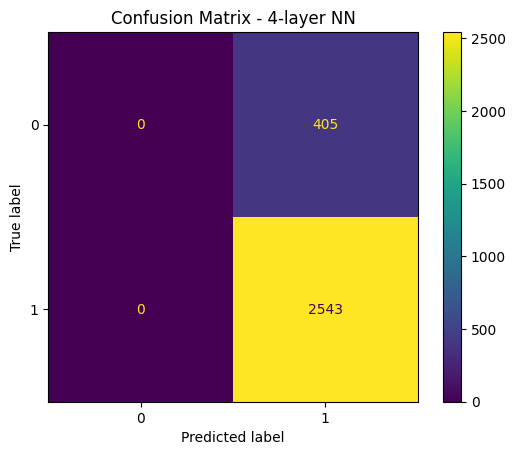

Confusion Matrix for 5-layer NN


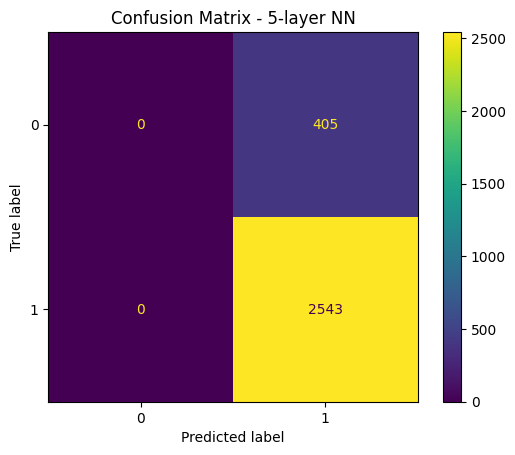

In [ ]:
models = trainMultipleModels(nn_configurations, SimpleNN, input_dim, output_dim)

# Try more complex structure, with batch norm and drop out

Training 2-layer NN...


100%|██████████| 300/300 [04:55<00:00,  1.02it/s]


2-layer NN Accuracy: 97.76%
Training 3-layer NN...


100%|██████████| 300/300 [05:50<00:00,  1.17s/it]


3-layer NN Accuracy: 97.69%
Training 4-layer NN...


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


4-layer NN Accuracy: 98.03%
Training 5-layer NN...


100%|██████████| 300/300 [07:36<00:00,  1.52s/it]


5-layer NN Accuracy: 98.13%
Training 6-layer NN...


100%|██████████| 300/300 [08:28<00:00,  1.69s/it]


6-layer NN Accuracy: 97.46%


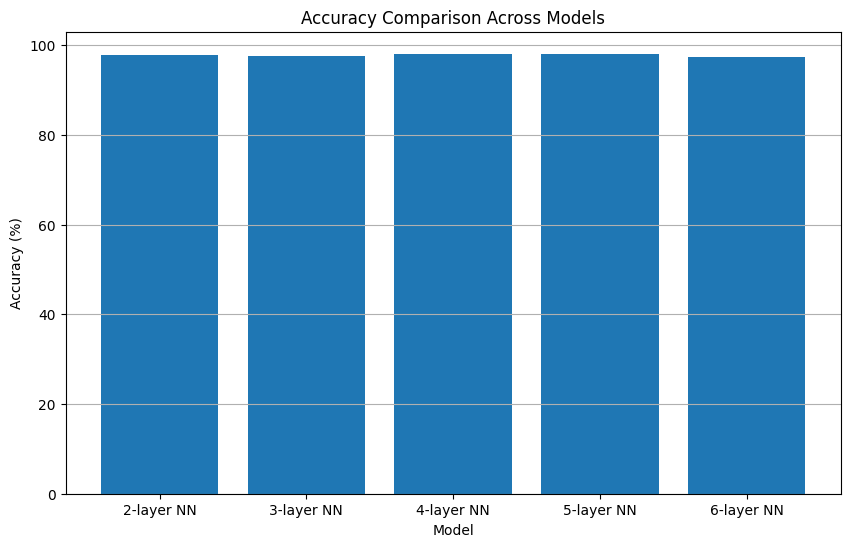

Confusion Matrix for 2-layer NN


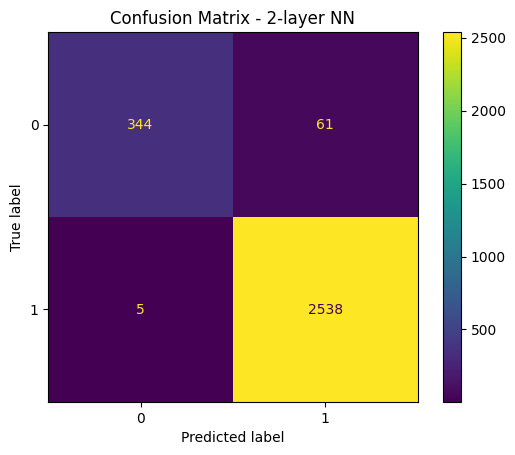

Confusion Matrix for 3-layer NN


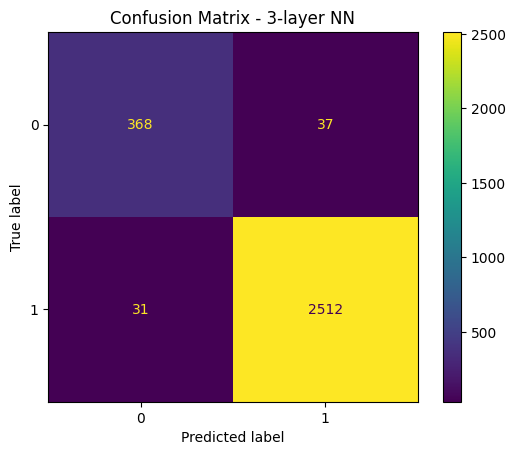

Confusion Matrix for 4-layer NN


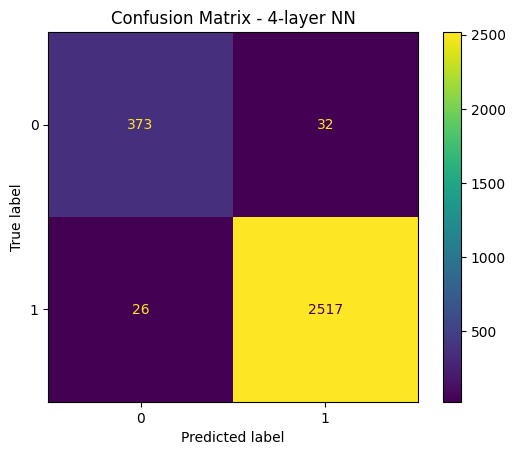

Confusion Matrix for 5-layer NN


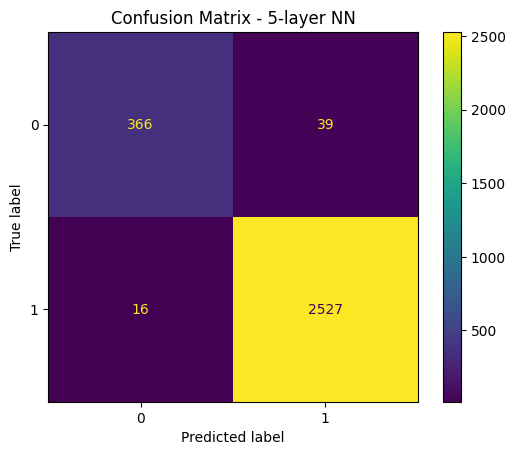

Confusion Matrix for 6-layer NN


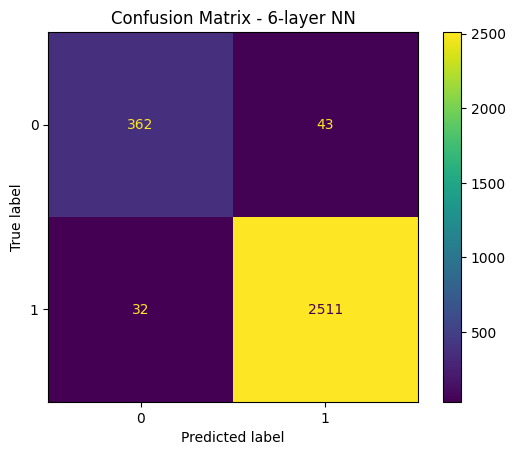

In [ ]:
class NN_BNorm_Dropout(nn.Module):
    def __init__(self, layers, input_dim, output_dim):
        super(NN_BNorm_Dropout, self).__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        for layer_dim in layers:
            self.layers.append(nn.Linear(prev_dim, layer_dim))
            self.layers.append(nn.BatchNorm1d(layer_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.3))
            prev_dim = layer_dim
        self.layers.append(nn.Linear(prev_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

complex_nn_configurations = {
    "2-layer NN": [128, 64],
    "3-layer NN": [256, 128, 64],
    "4-layer NN": [512, 256, 128, 64],
    "5-layer NN": [512, 256, 128, 64, 32],
    "6-layer NN": [512, 256, 128, 64, 32, 16]
}

complex_models = trainMultipleModels(complex_nn_configurations, NN_BNorm_Dropout, input_dim, output_dim)


In [ ]:
for i, name in enumerate(complex_nn_configurations.keys()):
  model_save_path = f"/content/drive/MyDrive/antispoofing/b14_LCC+5k_{i+2}Layers_BNorm_Dropout.pth"
  torch.save(complex_models[name], model_save_path)
  print("Model " + name + " saved at " + model_save_path)

Model 2-layer NN saved at /content/drive/MyDrive/antispoofing/b14_LCC+5k_2Layers_BNorm_Dropout.pth
Model 3-layer NN saved at /content/drive/MyDrive/antispoofing/b14_LCC+5k_3Layers_BNorm_Dropout.pth
Model 4-layer NN saved at /content/drive/MyDrive/antispoofing/b14_LCC+5k_4Layers_BNorm_Dropout.pth
Model 5-layer NN saved at /content/drive/MyDrive/antispoofing/b14_LCC+5k_5Layers_BNorm_Dropout.pth
Model 6-layer NN saved at /content/drive/MyDrive/antispoofing/b14_LCC+5k_6Layers_BNorm_Dropout.pth


# Try using just Dropout, without batch norm

In [ ]:
class NN_Dropout(nn.Module):
    def __init__(self, layers, input_dim, output_dim):
        super(NN_Dropout, self).__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        for layer_dim in layers:
            self.layers.append(nn.Linear(prev_dim, layer_dim))
            self.layers.append(nn.BatchNorm1d(layer_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.3))
            prev_dim = layer_dim
        self.layers.append(nn.Linear(prev_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

dropout_nn_configurations = {
    "2-layer NN": [128, 64],
    "3-layer NN": [256, 128, 64],
    "4-layer NN": [512, 256, 128, 64],
    "5-layer NN": [512, 256, 128, 64, 32],
    "6-layer NN": [512, 256, 128, 64, 32, 16]
}

complex_models = trainMultipleModels(dropout_nn_configurations, NN_Dropout, input_dim, output_dim)


Training Lightweight CNN model...
Lightweight CNN model Accuracy: 71.42%
Confusion Matrix for Lightweight CNN model


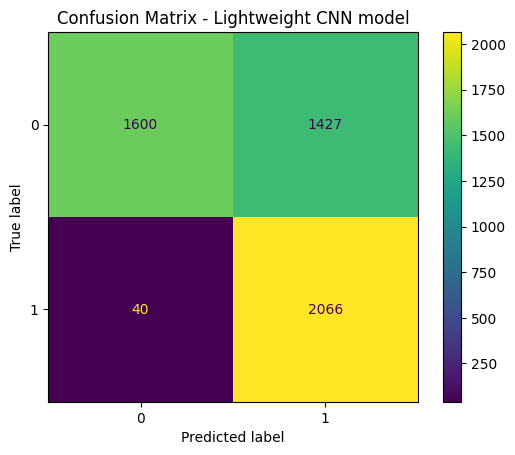

In [ ]:
class LightweightCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LightweightCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.fc1 = nn.Linear(input_dim // 4 * 64, 128)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding channel dimension for Conv1D
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.fc2(x)
        return x


In [ ]:
dev_labels[0]

tensor(0)

In [ ]:
dev_paths[0]

'drive/MyDrive/antispoofing/5kDataset/crop_face_real_v2/20240626_0751262648.jpg'

In [ ]:
print(train_labels[0])
print(train_paths[0])

tensor(0)
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_training/real/AA5742_id154_s0_112.png
